Teach a Seq2Seq Model to learn how to talk with General Adversarial Imitation Learning. Using a model + discriminator, teach the discriminator how to tell the difference between fake and real responses, and train the model using the policy gradient to fool the discriminator. Through this game, we can replicate conversations and see how the reward function produced by the discriminator evolves!

In [95]:

import torch
import sys
sys.path.append('../src')
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from models.utils import get_model
from models.config import TOKENS_RAW_CUTOFF
from models.seq2seqattn import init_weights, EncRnn, DecRnn, Seq2SeqAttn
from collections import deque
torch.autograd.set_detect_anomaly(True)

#Load in models and helper functions

w2v_model = get_model()
# w2ind from w2v
w2ind = {token: token_index for token_index, token in enumerate(w2v_model.wv.index2word)} 
# sorted vocab words
assert w2v_model.vocabulary.sorted_vocab == True
word_counts = {word: vocab_obj.count for word, vocab_obj in w2v_model.wv.vocab.items()}
word_counts = sorted(word_counts.items(), key=lambda x:-x[1])
words = [t[0] for t in word_counts]
# sentence marker token inds
sos_ind = w2ind['<sos>']
eos_ind = w2ind['<eos>']
# adjusted sequence length
SEQ_LEN = 5 + 2 # sos, eos tokens
# padding token
TRG_PAD_IDX = w2ind["."] # this is 0
# vocab, embed dims
VOCAB_SIZE, EMBED_DIM = w2v_model.wv.vectors.shape



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = EncRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM)
dec = DecRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
agent = Seq2SeqAttn(enc, dec, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)



In [96]:
class Discriminator(nn.Module):
    def __init__(self,model,SEQ_LEN):
        super(Discriminator, self).__init__()

        self.state_encoder = model.encoder
        self.action_encoder = model.encoder
        
        self.fc1 = nn.Linear(1280,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,1)
        self.src_len = torch.Tensor([int(SEQ_LEN)])
    def forward(self,x1,x2):
        state_z, _ = self.state_encoder(x1, self.src_len)
        action_z, _ = self.action_encoder(x2, self.src_len)

        state_action = torch.cat([state_z.flatten().unsqueeze(0), action_z.flatten().unsqueeze(0)],dim=1)
        
        state_action = torch.relu(self.fc1(state_action))
        state_action = torch.relu(self.fc2(state_action))
        state_action = torch.sigmoid(self.fc3(state_action))

        return state_action

In [97]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = EncRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM)
dec = DecRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
enc_ = EncRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM)
dec_ = DecRnn(hidden_size=64, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
agent = Seq2SeqAttn(enc, dec, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)
# load in pre-trained model 
agent_ = Seq2SeqAttn(enc_, dec_, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)
agent.load_state_dict(torch.load(
    '/scratch/nsk367/deepRL/limitation-learning/src/pretrained_generators/model-epoch10.pt'))
agent_.load_state_dict(torch.load(
    '/scratch/nsk367/deepRL/limitation-learning/src/pretrained_generators/model-epoch10.pt'))


discrim = Discriminator(model=agent_,SEQ_LEN=5).to(device)

In [98]:
# load in conversations (as a dictionary)
d = torch.load('../dat/processed/padded_vectorized_states_v3.pt')


In [99]:
import random
import math

In [100]:
def get_action_probs(model, input_state, sos_ind, eos_ind, SEQ_LEN, device):
    """
    Given an input sequence and policy, produce a distribution over tokens the predicted token for each step in the sequence. 
    """
    src_tensor = input_state.reshape(1,7).to(device)
    src_len = torch.Tensor([int(SEQ_LEN)])
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    #print('encoutshape',encoder_outputs.shape)
    mask = model.create_mask(src_tensor.transpose(1,0)).to(device)
    trg_indexes = [sos_ind]
    attentions = torch.zeros(SEQ_LEN, 1, len(input_state))
    outputs = []
    for i in range(SEQ_LEN):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
       # print(pred_token)
        if pred_token == eos_ind: # end of sentence.
        
            break
        outputs.append(output)
        
  #  trg_tokens = [words[int(ind)] for ind in trg_indexes]
    #  remove <sos>
    return F.softmax(torch.stack(outputs),dim=2).to(device)



    

In [101]:
def pad_action(action):
    num_pads = 7 - action.shape[0] - 2
    if num_pads == 0:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 0:
        action =torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
        
    if num_pads == 1:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 2:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),

                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 3:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),


                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 4:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),


                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 5:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),

                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    return action

In [102]:
def get_action(action_probs):
    action = []
    action_log_probs = []
    for i in action_probs:
        m = Categorical(i)
        action_ = m.sample()
        action_log_prob = m.log_prob(action_)# * reward
        action.append(action_.item())
        action_log_probs.append(action_log_prob)
    action = torch.Tensor(action).to(device).long()
    return action, torch.stack(action_log_probs)#.squeeze()

def get_reward(discrim, state, action):
    """
    The reward function according to irl. It's log D(s,a). 
    
    Reward is higher the closer this is to 0, because the more similar it is to an expert action. :
    Is quite close to imitation learning, but hope here is that with such a large number of expert demonstrations and entropy bonuses etc. it learns more than direct imitation. 
    """
    state = state.unsqueeze(0)
    action = action.unsqueeze(0)
    
    with torch.no_grad():
        #TODO: better resize
        return -math.log(discrim(state,action))
    
def train_discrim(memory, discrim_optim, args):
    """
    Training the discriminator. 

    Use binary cross entropy to classify whether 
    or not a sequence was predicted by the expert (real data) or actor. 
    """
    
    criterion = torch.nn.BCELoss() # classify
    learner = torch.stack([memory[i][0] for i in range(len(memory))])
    expert = torch.stack([memory[i][1] for i in range(len(memory))])
    policy_optim.zero_grad()
    discrim_optim.zero_grad()
    # actions came from expert or learner
    discrim_loss = criterion(learner.squeeze(1), torch.ones((args.batch_size, 1)).to(device)) + \
                    criterion(expert.squeeze(1), torch.zeros((args.batch_size, 1)).to(device))
            # discrim loss: predict agent is all wrong, get as close to 0, and predict expert is 1, getting as close to 1 as possible. 
    discrim_loss.backward()

    for _ in range(args.discrim_update_num):
        discrim_optim.step()
            # take these steps, do it however many times specified. 
        #return discrim(states,expert_actions) , discrim(states,actions)
    expert_acc = ((expert < 0.5).float()).mean().item()
    learner_acc = ((learner > 0.5).float()).mean().item()


    return discrim_loss.item(), expert_acc, learner_acc # accuracy, it's the same kind, but because imbalanced better to look at separately. 

def train_policy(memory, policy_optim, args):
    """
    Take several Policy Gradient steps to imporve the policy
    
    using the single step returns to optimize objective. 
    
    
    
    """
    
    rlog_probs = torch.cat([memory[i][0] for i in range(len(memory))])
    policy_optim.zero_grad()
    discrim_optim.zero_grad()

    policy_loss = rlog_probs.sum()
    policy_loss.backward()
    
    for _ in range(args.actor_critic_update_num):

        policy_optim.step()
    return policy_loss.item()

In [103]:
import torch.optim as optim


In [104]:
from argparse import Namespace
args = Namespace(load_model=None,
                agent_learning_rate=1e-9,
                discrim_learning_rate=1e-3,
                discrim_update_num=5,
                actor_critic_update_num=1,
                batch_size=512,
                suspend_accu_exp=None,# won't stop
                suspend_accu_gen=None,
                max_iter_num=50,
                logdir='logs/GAIL',
                )

In [105]:

policy_optim = optim.Adam(agent.parameters(), lr=args.agent_learning_rate)

discrim_optim = optim.Adam(discrim.parameters(), lr=args.discrim_learning_rate)


In [106]:
train_discrim_flag = True
train_policy_flag = True
policy_losses = []
discrim_losses = []
expert_accs = []
learner_accs = []

for step in range(args.max_iter_num):
    score = 0
    discrim_memory = deque()
    learner_memory = deque()
    trajectories = random.sample(d.items(),k=args.batch_size)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
       # print(action)]
        action = action.detach()
        action = pad_action(action)
        #print(action)
    
        #obtain what the estimated reward is for this 
        irl_reward = get_reward(discrim,input_state,action)
        score += irl_reward
        learner = discrim(input_state.unsqueeze(0).detach(), action.unsqueeze(0).detach()) #pass (s,a) through discriminator
        expert = discrim(input_state.unsqueeze(0), expert_action.unsqueeze(0)) #pass (s,a) through discriminator

        discrim_memory.append([learner,expert])
        learner_memory.append([-irl_reward  * action_log_probs])
    if train_policy_flag:
        policy_loss = train_policy(learner_memory, policy_optim, args)   
        policy_losses.append(policy_loss)
    print(score)
    if train_discrim_flag:
        discrim_loss, expert_acc, learner_acc = train_discrim(discrim_memory, discrim_optim, args) 
        print("Expert: %.2f%% | Learner: %.2f%%" % (expert_acc * 100, learner_acc * 100))
        discrim_losses.append(discrim_loss)
        expert_accs.append(expert_acc)
        learner_accs.append(learner_acc)


      #  writer.add_scalar('log/expert_acc', float(expert_acc), iter) #logg
      #  writer.add_scalar('log/learner_acc', float(learner_acc), iter) #logg
      #  writer.add_scalar('log/avg_acc', float(learner_acc + expert_acc)/2, iter) #logg
        if args.suspend_accu_exp is not None: #only if not None do we check.
            if expert_acc > args.suspend_accu_exp and learner_acc > args.suspend_accu_gen:
                train_discrim_flag = False
  
    expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
    action_tokens = " ".join([words[int(ind)] for ind in action])
    state_tokens = " ".join([words[int(ind)] for ind in input_state])
    print(state_tokens,'|',action_tokens,'|',expert_tokens)



374.0946650416587
Expert: 97.46% | Learner: 3.32%
<sos> who is that guy ? <eos> | <sos> , yeah . . <eos> | <sos> policy man in <gpe> . <eos>
199.73490183139234
Expert: 41.60% | Learner: 89.84%
<sos> there 's this guy ! <eos> | <sos> ? ? ? . <eos> | <sos> what ? . . . <eos>
1866.9278200194185
Expert: 100.00% | Learner: 0.00%
<sos> my folks are . . <eos> | <sos> here you here . <eos> | <sos> stay here . . . <eos>
424.5271300788552
Expert: 90.82% | Learner: 45.90%
<sos> you 're working late . <eos> | <sos> ? ? ? . <eos> | <sos> remember him ? . . <eos>
145.52843649712855
Expert: 34.77% | Learner: 96.29%
<sos> lunch ... . . . <eos> | <sos> love ... <loc> . <eos> | <sos> god ... . . . <eos>
124.9578781918649
Expert: 24.02% | Learner: 98.83%
<sos> pain . . . . <eos> | <sos> 'd you die . <eos> | <sos> the <org> again . . <eos>
199.04968052769382
Expert: 59.77% | Learner: 92.38%
<sos> it 's my nature . <eos> | <sos> is -- fun . <eos> | <sos> and this is mine . <eos>
270.4270960106011
Expert: 8

Now examine the results as plots

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline



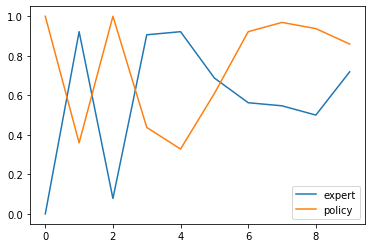

In [34]:
plt.plot(expert_accs,label='expert')
plt.plot(learner_accs,label='policy')
plt.legend()

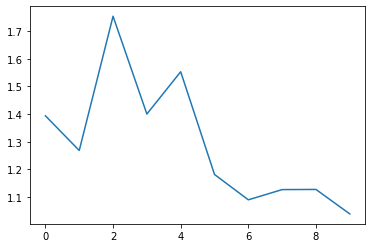

In [38]:
plt.plot(discrim_losses)

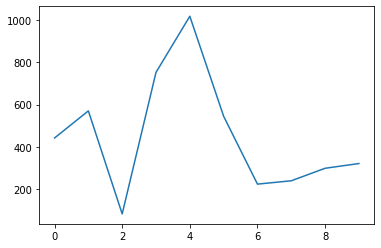

In [39]:
plt.plot(policy_losses)

# Policy Analysis


Using our best policy model, we now provide several examples from the policy network. 

In [42]:
for step in range(args.max_iter_num):
    trajectories = random.sample(d.items(),k=1)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
  
    expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
    action_tokens = " ".join([words[int(ind)] for ind in action])
    state_tokens = " ".join([words[int(ind)] for ind in input_state])
    print(state_tokens,'|',action_tokens,'|',expert_tokens)



<sos> what did she say ? <eos> | <sos> much he know . <eos> | <sos> beats me . . . <eos>
<sos> where 's the <cardinal> ? <eos> | <sos> 's other hand . <eos> | <sos> in your other hand . <eos>
<sos> you have beautiful eyes . <eos> | <sos> 'm <person> beautiful . <eos> | <sos> you have beautiful eyes . <eos>
<sos> we 've gone insane . <eos> | <sos> about fish ? . <eos> | <sos> yup . . . . <eos>
<sos> -- <person> ? . . <eos> | <sos> 'm n't know . <eos> | <sos> not anymore . . . <eos>
<sos> i 'm so scared ... <eos> | <sos> ... daddy go . <eos> | <sos> do n't be . . <eos>
<sos> <ordinal> time for everything . <eos> | <sos> was , ? . <eos> | <sos> that 's right . . <eos>
<sos> <org> is dead . . <eos> | <sos> me ? promise . <eos> | <sos> true . . . . <eos>
<sos> ahhh , ahhh ... . <eos> | <sos> 's you ? . <eos> | <sos> now what ? . . <eos>
<sos> tell me about them ... <eos> | <sos> ! no know . <eos> | <sos> if you like . . <eos>


# Discriminator Analysis

In [90]:
for step in range(args.max_iter_num):
    trajectories = random.sample(d.items(),k=1)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
        print(get_reward(discrim,input_state,expert_action), get_reward(discrim,input_state,action))
        
        
        expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
        action_tokens = " ".join([words[int(ind)] for ind in action])
        state_tokens = " ".join([words[int(ind)] for ind in input_state])
        print(state_tokens,'|',action_tokens,'|',expert_tokens)



1.1968682535165647 0.1672576715032808
<sos> who ? . . . <eos> | <sos> <person> <gpe> ? . <eos> | <sos> <person> . . . . <eos>
0.9659674721681502 0.08441950920040878
<sos> <person> ! from downstairs ! <eos> | <sos> love <gpe> ? . <eos> | <sos> ... hello . . . <eos>
1.3282960137090964 0.01328346982136546
<sos> down to my car . <eos> | <sos> ? ? ? . <eos> | <sos> why ? . . . <eos>
0.11238012448410264 0.45551689974704324
<sos> you getting this ? . <eos> | <sos> - none ! . <eos> | <sos> -- every word . . <eos>
1.3235711666246879 0.22317892729660663
<sos> you 're there now ? <eos> | <sos> , brother like . <eos> | <sos> oui . . . . <eos>
1.0117075128167796 1.0320269670309163
<sos> i could die . . <eos> | <sos> safe he ? . <eos> | <sos> so could i. . . <eos>
1.9660022703267888 0.26367019628551097
<sos> does that work ? . <eos> | <sos> mr. same yeah . <eos> | <sos> yeah ... seems to . <eos>
1.233673590936996 0.3479866089538975
<sos> you black ? . . <eos> | <sos> better better please . <eos> | <

In [59]:
input_state.shape

torch.Size([7])

In [91]:
i = 0
rewards = []
while i < 1000:
    random_inputs = [1929, random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928), 1930]
    random_action = torch.Tensor(random_inputs).long().cuda()
    rewards.append(get_reward(discrim,input_state,random_action))
    i += 1
    

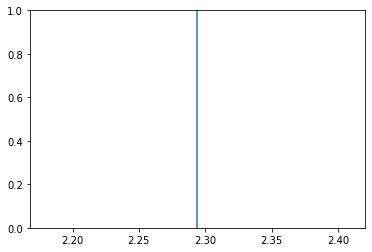

In [92]:
plt.axvline(get_reward(discrim,input_state,expert_action))

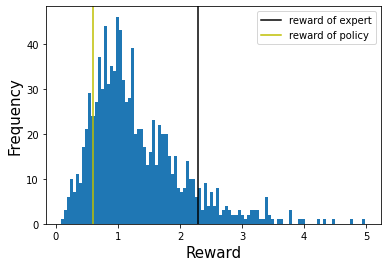

In [94]:
plt.hist(rewards,bins=100)
plt.axvline(get_reward(discrim,input_state,expert_action),color='k',label='reward of expert')
plt.axvline(get_reward(discrim,input_state,action),color='y',label='reward of policy')

plt.xlabel("Reward",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.legend()

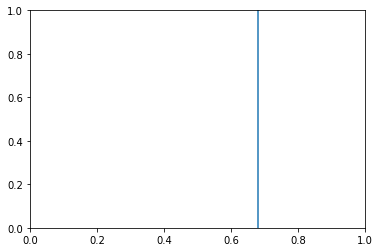

In [86]:
plt.axvline(get_reward(discrim,input_state,action),label='estimated reward of expert')
